In [4]:
import requests
import json
import re
import os
import pandas as pd 
import numpy as np
import random
import warnings

from sentence_transformers import SentenceTransformer, CrossEncoder
from ranker import TransformerRanker, CrossEncoderRanker, Classifier
from preprocessor import *
from mapper import Mapper
from display_products import DisplayProducts
import joblib
import pickle

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [24]:
# Set input file directory
ip_file_dir = "../../Data/"

# Get grocery product hierarchy information
group4 = pd.read_csv(os.path.join(ip_file_dir, 
                                   'group4_header.csv'),
                      sep=',', 
                      low_memory=False)

# Get scraped information for the above products
products = pd.read_csv(os.path.join(ip_file_dir,
                                    'scraped/products_group4.csv'))

# Merge scraped information into the hierarchy table
group4 = pd.merge(group4, products, 
                   how = 'left', on = 'tcin')

# Preprocess the table
group4 = preprocess_df(group4)

In [25]:
group4.head(2)

,Unnamed: 0,tcin,item_state,title,update_ts,brand_classification,brand_group,brand_id,brand,class_id,class_name,department_id,department_name,division_id,division_name,estore_item_status_c,estore_item_status,group_id,group_name,has_image,intended_selling_channels,is_published_flag,is_sellable,is_size_mix,is_standard_item,is_targetcom_ready,is_weight_required,item_kind,item_type_category_type,item_type_name,item_type,launch_date_time,manufacturer_brand,net_content_quantity_unit_of_measure,net_content_quantity_value,organic_c,package_depth,package_dimension_unit_of_measure,package_height,package_weight_unit_of_measure,package_weight,package_width,product_subtype_name,product_subtype,product_type_name,product_type,record_source_c,reference_color,reference_pattern_id,reference_size,relationship_kit_type,relationship_type_c,relationship_type,short_desc,size_chart,size_group_name,street_d,style_id,style_name,sub_group_id,sub_group_name,subclass_id,subclass_name,temperature_sensitivity_c,units_per_package,upc,variation_color,variation_other_label,variation_other,variation_size,variation_theme,price,rating,n_reviews,highlights,specifications,description,serving_info,nutrition_info,ingredients,allergens,images,image,title_modified,title_processed
0,19,10252241,READY_FOR_LAUNCH,Houdini Deluxe Lever Corkscrew,2021-10-05 02:17:34,National-National,National,18442.0,Houdini,5,KITCHEN TOOLS & GADGETS,70,KITCHENWARE,35,KITCHEN,A,Active,4,HOME,True,Sold in StoreSold Online,True,True,NaN,NaN,NaN,NaN,NaN,NaN,Corkscrews,104185519,2013-03-03 08:00:00,NaN,EACH,1.0,NaN,8.88,INCH,2.94,POUND,1.21,8.24,BARWARE,616.0,KITCHEN,636.0,Corona,NaN,NaN,NaN,NaN,SA,Stand Alone,CORKSCREW HOUDINI SILVER,NaN,NaN,NaN,070-05-02-AAR98,HOUDINI DLUX CORK,29,KITCHEN,070-05-02,BARWARE,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,29.99,3.6,30.0,"[3 Piece Set (Opener, Foil Cutter & Spiral), B...","[Includes: Bottle Opener, Extra Spiral, Foil C...",A high-quality lever-style corkscrew at a grea...,NaN,NaN,NaN,NaN,[https://target.scene7.com/is/image/Target/GUE...,https://target.scene7.com/is/image/Target/GUES...,houdini deluxe lever corkscrew,deluxe lever corkscrew
1,25,10386198,READY_FOR_LAUNCH,Kitchen Selectives Single Burner,2021-09-14 17:16:29,National-National,National,22771.0,Select Brands,4,SMALL APPLIANCES,72,SMALL APPLIANCES,35,KITCHEN,A,Active,4,HOME,True,Sold Online,True,True,NaN,NaN,NaN,NaN,NaN,NaN,Burners,298450,2006-10-08 07:00:00,NaN,EACH,1.0,NaN,9.50,INCH,4.00,POUND,1.95,10.50,COOKING APPLIANCES,651.0,KITCHEN,636.0,Corona,NaN,NaN,NaN,NaN,SA,Stand Alone,Kitchen Sele KITCH SELECT BURNER,NaN,NaN,NaN,072-04-11-AAB30,BURNER/HOTPLATE,29,KITCHEN,072-04-11,UTILITY APPLIANCES,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,26.49,4.2,60.0,"[Adjustable heat control, 1000 watt burner, Hi...","[, Dimensions (Overall): 2.9 Inches (H) x 8.7 ...",The Kitchen Selectives single burner gives you...,NaN,NaN,NaN,NaN,[https://target.scene7.com/is/image/Target/GUE...,https://target.scene7.com/is/image/Target/GUES...,kitchen selectives single burner,kitchen selectives single burner


In [26]:
# lm = SentenceTransformer('models/triplet-models/class_name_v2')
# clf = CrossEncoder('../../../../models/nli-classification-item_type_name')
lm = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

lm_embedder = SentenceTransformer('all-MiniLM-L6-v2')
glove_embedder = SentenceTransformer('average_word_embeddings_glove.6B.300d')
# multi_lm_embedder = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
mpnet_embedder = SentenceTransformer('all-mpnet-base-v2')
roberta_embedder = SentenceTransformer('all-distilroberta-v1')

In [27]:
# Get list of preprocessed product titles
product_ids = group4['tcin'].values

In [28]:
group4['class_name'] = np.where(pd.isnull(group4['class_name']), '', group4['class_name'])
group4['subclass_name'] = np.where(pd.isnull(group4['subclass_name']), '', group4['subclass_name'])
# group4['short_desc'] = np.where(pd.isnull(group4['short_desc']), '', group4['short_desc'])
group4['style_name'] = np.where(pd.isnull(group4['style_name']), '', group4['style_name'])
group4['item_type_name'] = np.where(pd.isnull(group4['item_type_name']), '', group4['item_type_name'])
# group4['highlights'] = np.where(pd.isnull(group4['highlights']), '', group4['highlights'])
# group4['description'] = np.where(pd.isnull(group4['description']), '', group4['description'])

product_sentences = list(group4['class_name'].str.cat(group4[['subclass_name', 
                                                                'item_type_name', 
                                                                'style_name', 'title'
                                                        ]], 
                                             sep= ' ').str.lower().values)


In [23]:
# Compute embeddings
pool = lm.start_multi_process_pool(target_devices=['cpu']*8)
emb = lm.encode_multi_process(product_sentences, pool)
# Store sentences & embeddings on disc
with open('../../data/embeddings/hier_embeddings_products4.pkl', "wb") as fOut:
    pickle.dump({'ids': product_ids,
                 'sentences': product_sentences, 
                 'embeddings': emb}, fOut, protocol=pickle.HIGHEST_PROTOCOL)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [19]:
# Compute embeddings
# pool = glove_embedder.start_multi_process_pool(target_devices=['cpu']*8)
# emb = glove_embedder.encode_multi_process(product_sentences, pool)
embeddings = lm_embedder.encode(product_sentences,convert_to_tensor=True)
# Store sentences & embeddings on disc
with open('/Users/chahaksethi/Desktop/Target/data/embeddings/lm_embeddings_products4.pkl', "wb") as fOut:
    pickle.dump({'ids': product_ids,
                 'sentences': product_sentences, 
                 'embeddings': embeddings}, fOut, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
df = pd.read_csv('/Users/chahaksethi/Desktop/Target/data/embeddings/glove.6B.300d.txt', sep=" ", quoting=3, header=None, index_col=0)
glove = {key: val.values for key, val in df.T.items()}

with open('/Users/chahaksethi/Desktop/Target/data/embeddings/glove_embeddings_group4.pkl', 'wb') as fp:
    pickle.dump(glove, fp)

In [29]:
#Load sentences & embeddings from disc
with open('../../data/embeddings/hier_embeddings_products4.pkl', "rb") as fIn:
    stored_data = pickle.load(fIn)
    stored_ids = stored_data['ids']
    stored_sentences = stored_data['sentences']
    stored_embeddings = stored_data['embeddings']

In [30]:
tr = TransformerRanker(model=lm, product_ids=product_ids, max_rank=6)
tr.load_embeddings(stored_embeddings)
pm = Mapper(group4)
dp = DisplayProducts(ranker=tr, mapper=pm)

In [31]:
bi_encoder_name = "multi-qa-MiniLM-L6-cos-v1"
cross_encoder_name = "cross-encoder/ms-marco-MiniLM-L-4-v2"
embedding_loc = '../../data/embeddings/hier_embeddings_products4.pkl'

clf_name_class_name = '/Users/mvellera/data/practicum/models/nli-classification-class_name'
clf_name_item_type_name = '../../../../models/nli-classification-item_type_name'
clf_name_subclass_name = '../../../../models/nli-classification-subclass_name'

k=3

In [32]:
base_clf_class_name = CrossEncoder(clf_name_class_name)
base_clf_item_type_name = CrossEncoder(clf_name_item_type_name)
base_clf_subclass_name = CrossEncoder(clf_name_subclass_name)

clf_class_name = Classifier(base_clf_class_name, pm, 'class_name', threshold=0.99)
clf_item_type_name = Classifier(base_clf_item_type_name, pm, 'item_type_name', threshold=0.99)
clf_subclass_name =  Classifier(base_clf_subclass_name, pm, 'subclass_name', threshold=0.99)

In [33]:
def get_embeddings(path):
#Load sentences & embeddings from disc
    with open(path, "rb") as fIn:
        stored_data = pickle.load(fIn)
        stored_embeddings = stored_data['embeddings']
    return stored_embeddings
    
def get_tcin_sentence_map(path):
#Load sentences & embeddings from disc
    with open(path, "rb") as fIn:
        stored_data = pickle.load(fIn)
        df = pd.DataFrame()
        df['tcin'] = stored_data['ids']
        df['sentence'] = stored_data['sentences']
    return df

bi_encoder = SentenceTransformer(bi_encoder_name)

# Get list of preprocessed product titles
product_titles = group4['title'].str.lower().values

l1_ranker = TransformerRanker(model=bi_encoder, 
                              product_ids=group4['tcin'], 
                              max_rank=k,
                              clf=[clf_class_name,
                                   clf_item_type_name,
                                   clf_subclass_name])
with open(embedding_loc, "rb") as fIn:
    stored_data = pickle.load(fIn)
    stored_ids = stored_data['ids']
    stored_sentences = stored_data['sentences']
    stored_embeddings = stored_data['embeddings']
df = pd.DataFrame()
df['id'] = stored_data['ids']
df['sentence'] = stored_data['sentences']
l1_ranker.load_embeddings(stored_embeddings)

In [34]:
cross_encoder_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-12-v2', max_length=512)
pm = Mapper(group4)
l2_ranker = CrossEncoderRanker(bi_model=l1_ranker, 
                                cross_model=cross_encoder_model, 
                                tcin_sentence_map=get_tcin_sentence_map(embedding_loc),
                                cross_rank=k,
                                bi_rank=30,
                                mapper=pm,
                                weights=True)

dp = DisplayProducts(ranker=l2_ranker, mapper=pm)
# dp = DisplayProducts(ranker=l1_ranker, mapper=pm)

Filtered pan for item_type_name: Indoor Trash Cans
pan
[81801118, 76190391, 83776543, 52355650, 83776447, 76739081, 76181945, 84262198, 84262184, 84262208]


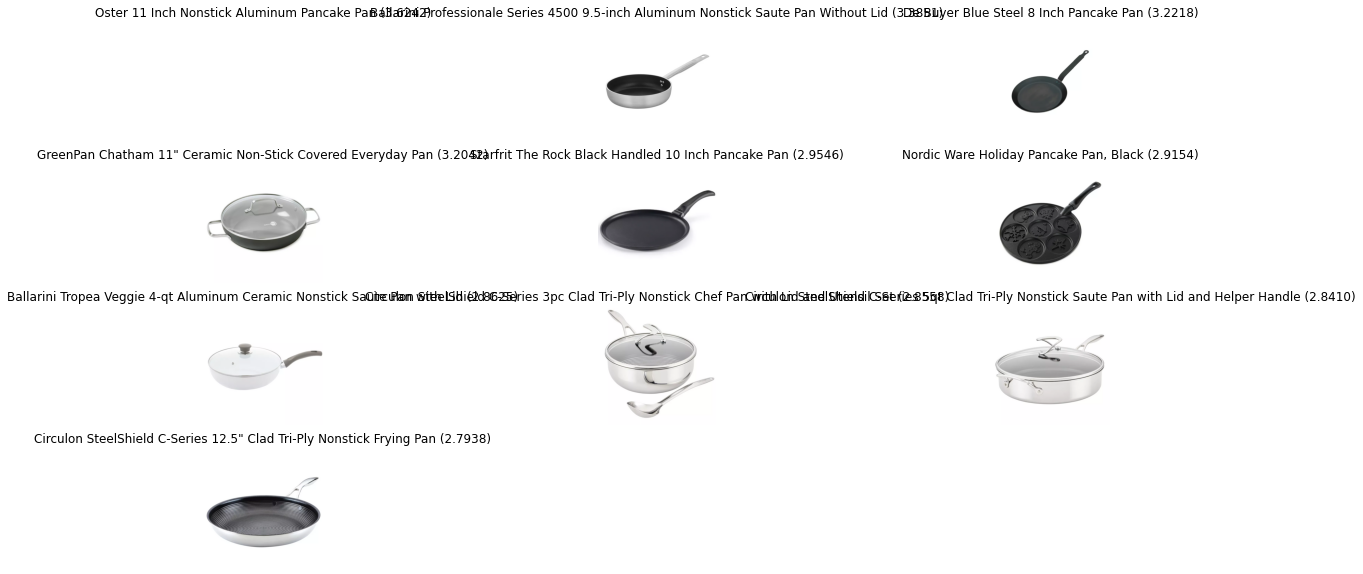

In [35]:
dp.display_products_ingredient('pan', 10)